<a href="https://colab.research.google.com/github/kelangray/Neural-ODEs/blob/main/Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    from torchdyn.core import NeuralODE
except ImportError:
    !pip install torchdyn
    from torchdyn.core import NeuralODE

try:
    import torch
except ImportError:
    !pip install torch

from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Augmented Neural ODEs

In this notebook, we explore how Augmented Neural ODEs can learn simpler trajectories.

### Brief Motivation

Consider a classification task. Neural ODEs learn dynamics of the form:

$$
\frac{dX(t)}{dt} = f_\theta(X(t), t), \quad X(0) = x
$$

A key limitation is that their solutions to the above ODE cannot have intersecting trajectories. This means Neural ODEs will struggle to learn certain classes of functions.

Augmented Neural ODEs were introduced by Dupont et al. to address these limitations. See their paper:

> Dupont, E., Doucet, A., & Teh, Y. W. (2019). [Augmented Neural ODEs](https://arxiv.org/pdf/1904.01681).



###Visualize the dataset.



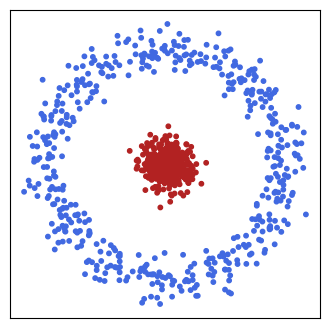

In [ ]:
from sklearn.datasets import make_circles

colors = ["royalblue", "firebrick"]
cmap = LinearSegmentedColormap.from_list("my_cmap", colors)

#Generate dataset
n_samples = 1000
noise = 0.1
X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.05)

#Visualize dataset
plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=10)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
#Load data into dataloader
device = torch.device("cpu")
X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(y).to(device)
train = TensorDataset(X_train, y_train)
trainloader = DataLoader(train, batch_size=len(X), shuffle=False)

### Train a Vanilla Neural ODE




In [ ]:
t_span = torch.linspace(0, 1, 5)

f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [ ]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop over epochs
num_epochs = 250
loss_baseline = []
for epoch in range(num_epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(trainloader):
        # Move the data to the appropriate device
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass through the model
        t_eval, y_hat = model(x_batch, t_span)

        # Select the last point of the solution trajectory
        loss =  nn.CrossEntropyLoss()(y_hat[-1], y_batch)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        loss_baseline.append(loss.item())

    if epoch%10 == 0:
        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/250], Loss: 0.7441520094871521
Epoch [11/250], Loss: 0.6976726055145264
Epoch [21/250], Loss: 0.6905432343482971
Epoch [31/250], Loss: 0.6873188018798828
Epoch [41/250], Loss: 0.680202066898346
Epoch [51/250], Loss: 0.6569204330444336
Epoch [61/250], Loss: 0.5841829180717468
Epoch [71/250], Loss: 0.45579004287719727
Epoch [81/250], Loss: 0.3377888798713684
Epoch [91/250], Loss: 0.2539534568786621
Epoch [101/250], Loss: 0.1990882158279419
Epoch [111/250], Loss: 0.1571078598499298
Epoch [121/250], Loss: 0.12775464355945587
Epoch [131/250], Loss: 0.10797779262065887
Epoch [141/250], Loss: 0.09346304088830948
Epoch [151/250], Loss: 0.08221223950386047
Epoch [161/250], Loss: 0.07277688384056091
Epoch [171/250], Loss: 0.06464453786611557
Epoch [181/250], Loss: 0.05757807567715645
Epoch [191/250], Loss: 0.05133781582117081
Epoch [201/250], Loss: 0.04587816819548607
Epoch [211/250], Loss: 0.04184851050376892
Epoch [221/250], Loss: 0.03754882887005806
Epoch [231/250], Loss: 0.034182883

###Evolution of Training Data




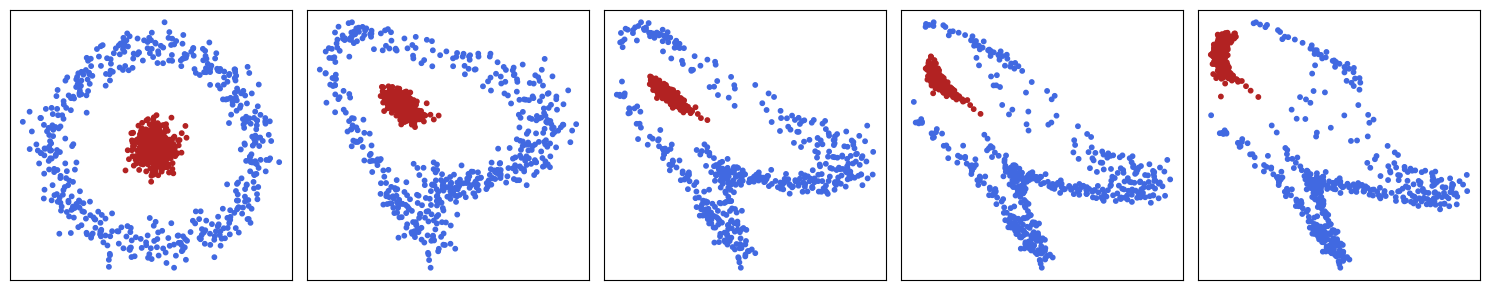

In [ ]:
t_span = torch.linspace(0, 1, 50)
traj = model.trajectory(X_train, t_span).detach().cpu()

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].scatter(traj[i*10, :, 0], traj[i*10, :, 1], c=y, cmap=cmap, s=10)
    axes[i].set_xticks([])  # Remove x-axis numbers
    axes[i].set_yticks([])  # Remove y-axis numbers
plt.tight_layout()
plt.show()

##Augmentation

Let's train an Augmented Neural ODE using 0-Augmentation:

$$
\begin{cases}
\frac{d}{dt} \begin{pmatrix} X(t) \\ Y(t) \end{pmatrix} = f_\theta \left( \begin{pmatrix} X(t) \\ Y(t) \end{pmatrix}, t \right), \\
\begin{pmatrix} X(0) \\ Y(0) \end{pmatrix} = \begin{pmatrix} x \\ 0 \end{pmatrix}
\end{cases}
$$

In [ ]:
#Augment data with Zeros
zeros = np.zeros((n_samples, 1))
X_train_aug = np.concatenate((X, zeros), axis=1)

In [ ]:
#Load data into PyTorch Loader
X_train_aug = torch.Tensor(X_train_aug).to(device)
y_train = torch.LongTensor(y).to(device)
train_aug = TensorDataset(X_train_aug, y_train)
trainloader_aug = DataLoader(train_aug, batch_size=len(X), shuffle=False)

### Train our Augmented Neural ODE

In [ ]:
t_span = torch.linspace(0, 1, 5) #Timespan to integrate over

# Define parameterized vector field and Neural ODE model
f_aug = nn.Sequential(
    nn.Linear(3, 16),
    nn.Tanh(),
    nn.Linear(16, 3)
)

aug_model = NeuralODE(f_aug, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5').to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


In [ ]:
#Define the optimizer
optimizer = optim.Adam(aug_model.parameters(), lr=0.01)

#Training loop over epochs
num_epochs = 250
loss_aug = []
for epoch in range(num_epochs):
    for batch_idx, (x_batch, y_batch) in enumerate(trainloader_aug):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  #Clear previous gradients

        #Forward pass through the model
        t_eval, aug_traj = aug_model(x_batch, t_span)

        #Compute loss on last point of the solution trajectory
        loss =  nn.CrossEntropyLoss()(aug_traj[-1], y_batch)
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update the weights

        loss_aug.append(loss.item())

    if epoch%10 == 0:
        # Print the average loss for this epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")

Epoch [1/250], Loss: 1.2556103467941284
Epoch [11/250], Loss: 0.9127591848373413
Epoch [21/250], Loss: 0.749954879283905
Epoch [31/250], Loss: 0.6964600086212158
Epoch [41/250], Loss: 0.6778384447097778
Epoch [51/250], Loss: 0.6586838960647583
Epoch [61/250], Loss: 0.6165173053741455
Epoch [71/250], Loss: 0.49318718910217285
Epoch [81/250], Loss: 0.319438636302948
Epoch [91/250], Loss: 0.18953724205493927
Epoch [101/250], Loss: 0.1122860237956047
Epoch [111/250], Loss: 0.04932154342532158
Epoch [121/250], Loss: 0.022798044607043266
Epoch [131/250], Loss: 0.01208767481148243
Epoch [141/250], Loss: 0.007339676842093468
Epoch [151/250], Loss: 0.004419470671564341
Epoch [161/250], Loss: 0.0030148732475936413
Epoch [171/250], Loss: 0.002274780534207821
Epoch [181/250], Loss: 0.0018300770316272974
Epoch [191/250], Loss: 0.00153391866479069
Epoch [201/250], Loss: 0.0013210857287049294
Epoch [211/250], Loss: 0.0011592047521844506
Epoch [221/250], Loss: 0.0010308168129995465
Epoch [231/250], Lo

###Evolution of Training Data

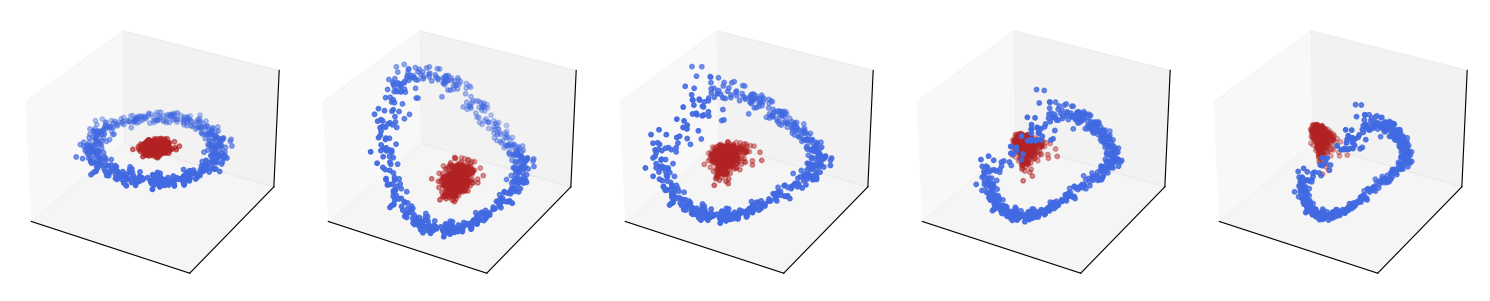

In [ ]:
#Retrieve trajectories
t_span = torch.linspace(0, 1, 50)
aug_traj = aug_model.trajectory(X_train_aug, t_span).detach().cpu()

#Create 3D subplots
fig = plt.figure(figsize=(15, 5))
axes = [fig.add_subplot(1, 5, i+1, projection='3d') for i in range(5)]

for i in range(5):
    axes[i].scatter(aug_traj[i*10, :, 0], aug_traj[i*10, :, 1], aug_traj[i*10, :, 2], c=y, cmap=cmap, s=10)
    axes[i].set_xticks([])  # Remove x-axis numbers
    axes[i].set_yticks([])  # Remove y-axis numbers
    axes[i].set_zticks([])  # Remove z-axis numbers
plt.tight_layout()
plt.show()

### Visualize Trajectories

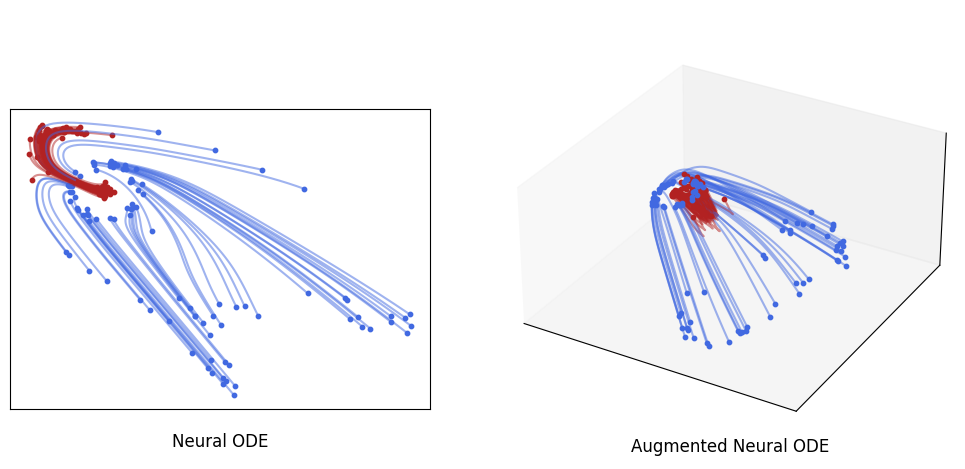

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

#2D Trajectories of Neural ODE
ax1 = fig.add_axes([0.05, 0.2, 0.35, 0.6])
for idx, label in enumerate(y):
    if idx % 10 == 0:
        trajectory = traj[:, idx, :]
        color = 'royalblue' if label == 0 else 'firebrick'
        ax1.plot(trajectory[:, 0], trajectory[:, 1], color=color, alpha=0.5)
        ax1.scatter(trajectory[0, 0], trajectory[0, 1], color=color, s=10)
        ax1.scatter(trajectory[-1, 0], trajectory[-1, 1], color=color, s=10)
ax1.set_xticks([]), ax1.set_yticks([])
ax1.set_title("Neural ODE", y=-0.15)

#3D Trajectories of Augmented Neural ODE
ax2 = fig.add_axes([0.45, 0.1, 0.4, 0.9], projection='3d')
for idx, label in enumerate(y):
    if idx % 10 == 0:
        traj = aug_traj[:, idx, :]
        color = 'royalblue' if label == 0 else 'firebrick'
        ax2.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=color, alpha=0.5)
        ax2.scatter(aug_traj[0, idx, 0], aug_traj[0, idx, 1], aug_traj[0, idx, 2], color=color, s=10)
        ax2.scatter(aug_traj[-1, idx, 0], aug_traj[-1, idx, 1], aug_traj[-1, idx, 2], color=color, s=10)

ax2.set_box_aspect([2, 2, 1])  # Equal aspect ratio
ax2.grid(False)
ax2.set_xticks([]), ax2.set_yticks([]), ax2.set_zticks([])
ax2.set_title("Augmented Neural ODE", y=0)

# Show the plots
plt.subplots_adjust(wspace=0.0)
plt.show()
